# Social Network Community Detection

In [1]:
import pandas as pd
import networkx as nx
import itertools
import community
import csv
import matplotlib.pyplot as plt
from pyecharts import options as opts
from pyecharts.charts import Graph
from datetime import timedelta
from wordcloud import WordCloud
from collections import Counter

In [13]:
df = pd.read_csv('dataset_TSMC2014_NYC.csv')
df['utcTimestamp'] = pd.to_datetime(df['utcTimestamp'], format='%a %b %d %H:%M:%S +0000 %Y')

# delete some meaningless places
drop_list = ['Subway', 'Home (private)', 'Bus Station', 'Train Station', 'Road', 'Airport']

# Create a condition for the rows to be deleted
condition = df['venueCategory'].isin(drop_list)

# Use the condition to drop the rows
df = df[~condition]

venue_freq = df['venueId'].value_counts().to_dict()
category_freq = df['venueCategory'].value_counts().to_dict()

# # count the frequency of venues and delete the top 15 frequence venues
# venue_freq_series = pd.Series(venue_freq)
# top_15_venues = venue_freq_series.nlargest(15).index
# df = df[~df['venueId'].isin(top_15_venues)]
print(len(df['userId'].unique()))

1083


## Social Network Construction

In [3]:
# create graph
G = nx.Graph()
# generate nodes
for user_id in df['userId'].unique():
    G.add_node(user_id)

In [4]:
# generate edge with weight
# - if two users visit more same places, the higher the weight between them will be
# - if two users visit the same places closer in time (different date), the higher the weight between them will be
user_venues = df.groupby('userId')['venueId'].apply(set).to_dict()
user_venue_visits = df.groupby(['userId', 'venueId'])['utcTimestamp'].apply(list).to_dict()

for user1, user2 in itertools.combinations(df['userId'].unique(), 2):
    # Find common venues
    common_venues = user_venues[user1] & user_venues[user2]
    
    # Initiate weight
    weight = 0
    
    # For each common venue
    for venue in common_venues:
        # Get the visit times for each user at this venue
        # Get the visit times for each user at this venue and convert them to lists
        user1_visits = user_venue_visits.get((user1, venue), [])
        user2_visits = user_venue_visits.get((user2, venue), [])
        
        # Count the number of visits
        a_freq = len(user1_visits)
        b_freq = len(user2_visits)
        
        # Count the times when they have visited the same venue within an hour or within a day
        # Initialize the pointers
        i, j = 0, 0

        # Initialize the counters
        visits_within_hour = 0
        visits_within_day = 0

        # While both pointers are within the range of their respective lists
        while i < len(user1_visits) and j < len(user2_visits):
            # If the absolute difference between the two visits is within an hour
            if abs(user1_visits[i] - user2_visits[j]) <= timedelta(hours=1):
                visits_within_hour += 1
            # If the absolute difference between the two visits is within a day but not within an hour
            elif abs(user1_visits[i] - user2_visits[j]) <= timedelta(days=1):
                visits_within_day += 1
            # Move the pointer that points to the earlier visit
            if user1_visits[i] < user2_visits[j]:
                i += 1
            else:
                j += 1
        
        # Update the frequencies
        a_freq += 2 * visits_within_hour + visits_within_day
        b_freq += 2 * visits_within_hour + visits_within_day
        
        # Update the weight
        if abs(a_freq - b_freq) == 0:
            weight += (a_freq + b_freq) / venue_freq[venue]
        else:
            weight += (a_freq + b_freq) / abs(a_freq - b_freq) / venue_freq[venue]
    
    # Add the edge to the graph
    if weight > 1:
        G.add_edge(user1, user2, weight=weight)

In [5]:
# visualize the original graph
# Prepare data for Pyecharts
nodes = [{"name": str(node)} for node in G.nodes()]
links = [{"source": str(edge[0]), "target": str(edge[1]), "value": str(G.edges[edge]['weight'])} for edge in G.edges()]
# Create the Pyecharts graph

graph = (
    Graph()
    .add("", nodes, links, repulsion=8000)
    .set_global_opts(title_opts=opts.TitleOpts(title="Network Graph made with Pyecharts"))
)

# Render the graph
graph.render('output.html')

'd:\\Documents\\Desktop\\23Fall\\Social_Network_Mining\\PJ\\output.html'

## Community Detection

In [5]:
# Compute the partition using Python-Louvain
partition = community.best_partition(G, weight='weight')
community_counts = Counter(partition.values())
print(community_counts)

Counter({6: 196, 3: 159, 2: 135, 4: 122, 7: 115, 5: 84, 14: 68, 15: 67, 12: 62, 0: 23, 21: 13, 1: 1, 9: 1, 10: 1, 11: 1, 16: 1, 17: 1, 18: 1, 20: 1, 22: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 8: 1, 19: 1, 13: 1, 23: 1})


In [7]:
# save the partition result in csv
with open('community_partition.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Node', 'Community'])
    for key, value in partition.items():
        writer.writerow([key, value])

In [39]:
# visualize the communities
# Assuming 'partition' is your community partition dictionary
communities = set(partition.values())

# Create a Graph instance
new_graph = Graph()

count = 0

for community in communities:
    # Create a subgraph for each community
    subgraph = G.subgraph([node for node in partition if partition[node] == community])

    # Create nodes and links for pyecharts
    nodes = [{"name": str(node)} for node in subgraph.nodes()]
    links = [{"source": str(edge[0]), "target": str(edge[1]), "value": str(G[edge[0]][edge[1]]['weight'])} for edge in subgraph.edges()]

    # Add nodes and links to the graph
    new_graph.add("", nodes, links)
    count+=1
    if count == 5:
        break

# Set global options
new_graph.set_global_opts(title_opts=opts.TitleOpts(title="Communities"))

# Render the graph
# new_graph.render_notebook()


## Community Analysis

[87, 135, 284, 15, 280, 318, 164, 1055, 793, 539, 688, 756, 129, 420, 519, 526, 611, 47, 192, 279, 586, 637, 973, 805, 940, 418, 1076, 90, 989, 198, 772, 799, 361, 296, 826, 475, 54, 1013, 1042, 362, 251, 367, 903, 417, 312, 370, 21, 170, 1064, 614, 372, 114, 405, 440, 339, 167, 981, 10, 73, 175, 1001, 275, 727, 356, 918, 561, 282, 465, 153, 46, 423, 208, 332, 171, 277, 568, 58, 305, 680, 1073, 283, 334, 601, 566, 967, 55, 674, 564, 166, 368, 608, 353, 518, 907, 659, 833, 206, 122, 982, 888, 160, 717, 1053, 893, 245, 1048, 214, 977, 668, 1007, 856, 39, 737, 330, 776, 569, 295, 644, 780, 462, 939, 384, 863, 213, 613, 703, 745, 257, 869, 814, 760, 590, 1039, 588, 127, 142, 62, 325, 1056, 286, 416, 915, 685, 664, 550, 429, 832, 262, 486, 676, 239, 165, 523, 732, 538, 109, 764, 437, 998]
Counter({'Swiss Restaurant': 0.9166666666666666, 'Recycling Facility': 0.9107142857142857, 'Scandinavian Restaurant': 0.45454545454545453, 'Eastern European Restaurant': 0.45454545454545453, 'Salad Place':

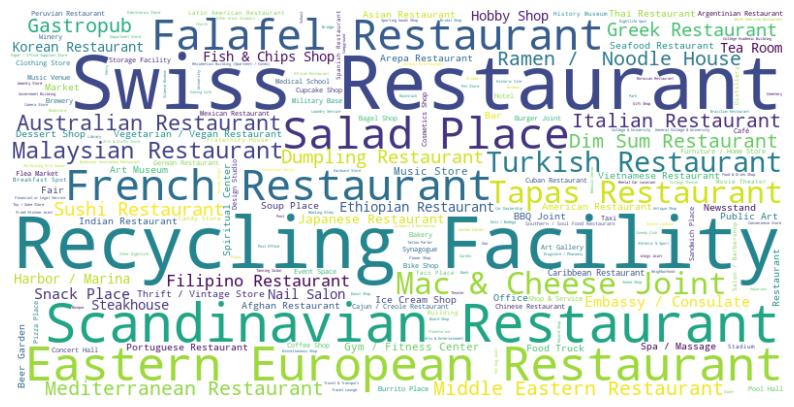

In [21]:
target_community = 3

nodes_in_target_community = [node for node, comm in partition.items() if comm == target_community]

print(nodes_in_target_community)

target_text = []

for nodes in nodes_in_target_community:
    target_text += list(df[df['userId'] == nodes]['venueCategory'])

frequencies = Counter(target_text)
for key in frequencies.keys():
    frequencies[key] /= category_freq[key]

print(frequencies)


wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(frequencies=frequencies)

# 绘制词云图
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 不显示坐标轴
plt.show()